In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing # Normalization
from sklearn.model_selection import train_test_split
from scipy.stats import f_oneway # ANOVA
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras import backend as K
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
tf.compat.v1.disable_eager_execution()

# 1 DATA LOADING + PREPROCESSING

In [ ]:
raw_df = pd.read_csv('/content/drive/My Drive/Classroom/Biomedical Data Science & AI/veer1_expression.csv', sep = ';', header = None, index_col = 0)
raw_df = raw_df.T
labels = pd.read_csv('/content/drive/My Drive/Classroom/Biomedical Data Science & AI/veer1_clinical.csv', sep = ';')
labels.index += 1
raw_df['class'] = labels['class']
df_grouped = raw_df.groupby(['class'])
df_NODM = df_grouped.get_group('NODM').iloc[:,:-1]
df_DM = df_grouped.get_group('DM').iloc[:,:-1]

In [ ]:
F_test = []
for gene in df_NODM.columns:
  _, p_val = f_oneway(df_DM[gene], df_NODM[gene])
  F_test.append((gene, p_val))
top100_pval = sorted(F_test, key = lambda x: x[1])[:100]
top100_genes, _ = zip(*top100_pval)
work_df = raw_df[raw_df.columns.intersection(top100_genes)]

In [ ]:
# Normalization to mean 0 and std = 1 since activation function is going to be tanh (minimizes gradient vanishing)
#scaler = preprocessing.MinMaxScaler((-1, 1))
#work_df = pd.DataFrame(scaler.fit_transform(work_df), columns = work_df.columns, index = work_df.index)
work_df = pd.DataFrame(preprocessing.scale(work_df), columns = work_df.columns, index = work_df.index)
X_train, X_test, y_train, y_test = train_test_split(work_df, raw_df['class'], test_size = 0.2, random_state = 0)

# 2 DEFINE A BOTTLENECK VAE STRUCTURE

In [ ]:
input_shape = len(work_df.columns)
batch_size = 8
epochs = 50
validation_split = 0.2
verbosity = 1
latent_dim = 2

In [ ]:
i = tf.keras.layers.Input(shape = input_shape, name = 'en_input')
hx = tf.keras.layers.Dense(input_shape / 2, activation = 'tanh', kernel_initializer = tf.keras.initializers.GlorotNormal(), name = 'en_hd_1')(i)
hx = tf.keras.layers.BatchNormalization()(hx)
hx = tf.keras.layers.Dense(input_shape / 4, activation = 'tanh', kernel_initializer = tf.keras.initializers.GlorotNormal(), name = 'en_hd_2')(hx)
hx = tf.keras.layers.BatchNormalization()(hx)
mu = tf.keras.layers.Dense(latent_dim, name = 'latent_mu')(hx)
sigma = tf.keras.layers.Dense(latent_dim, name = 'latent_sigma')(hx)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
hd_shape = K.int_shape(hx)

In [ ]:
def sample_z(args):
  mu, sigma = args
  batch = K.shape(mu)[0]
  dim = K.int_shape(mu)[1]
  eps = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

In [ ]:
z = tf.keras.layers.Lambda(sample_z, output_shape = (latent_dim,), name = 'z')([mu, sigma])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
en_input (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
en_hd_1 (Dense)                 (None, 50)           5050        en_input[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 50)           200         en_hd_1[0][0]                    
__________________________________________________________________________________________________
en_hd_2 (Dense)                 (None, 25)           1275        batch_normalization[0][0]        
____________________________________________________________________________________________

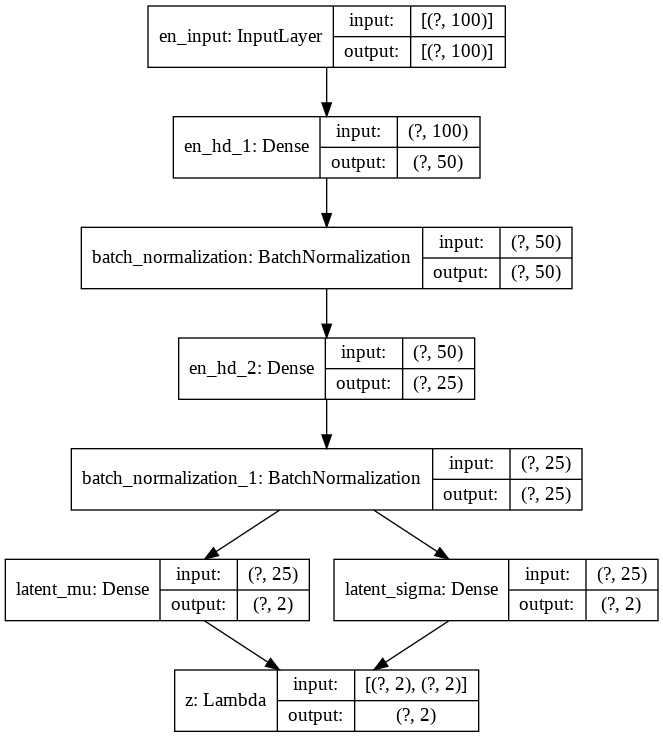

In [ ]:
encoder = tf.keras.Model(i, [mu, sigma, z], name='encoder')
encoder.summary()
tf.keras.utils.plot_model(encoder, show_shapes=True)

In [ ]:
d_i = tf.keras.layers.Input(shape = (latent_dim,), name = 'de_input')
hx = tf.keras.layers.Dense(hd_shape[1], activation = 'tanh', kernel_initializer = tf.keras.initializers.GlorotNormal(), name = 'de_hd_1')(d_i)
hx = tf.keras.layers.BatchNormalization()(hx)
hx = tf.keras.layers.Dense(input_shape / 2, activation = 'tanh', kernel_initializer = tf.keras.initializers.GlorotNormal(), name = 'de_hd_2')(hx)
hx = tf.keras.layers.BatchNormalization()(hx)
x = tf.keras.layers.Dense(input_shape, activation = 'tanh', kernel_initializer = tf.keras.initializers.GlorotNormal(), name = 'de_out')(hx)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
de_input (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
de_hd_1 (Dense)              (None, 25)                75        
_________________________________________________________________
batch_normalization_2 (Batch (None, 25)                100       
_________________________________________________________________
de_hd_2 (Dense)              (None, 50)                1300      
_________________________________________________________________
batch_normalization_3 (Batch (None, 50)                200       
_________________________________________________________________
de_out (Dense)               (None, 100)               5100      
Total params: 6,775
Trainable params: 6,625
Non-trainable params: 150
_______________________________________________________

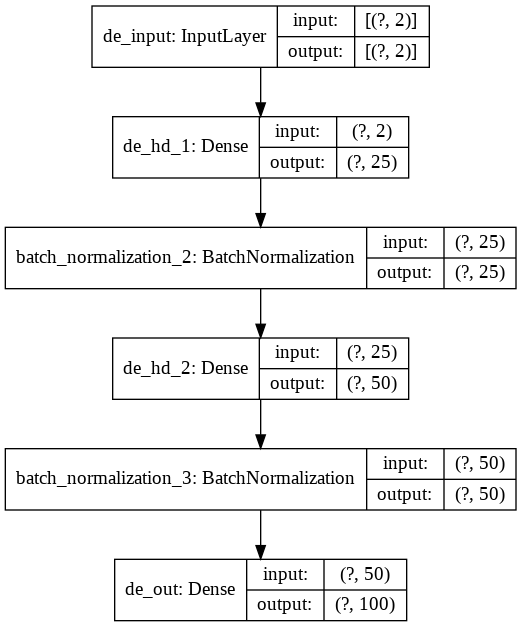

In [ ]:
decoder = tf.keras.Model(d_i, x, name='decoder')
decoder.summary()
tf.keras.utils.plot_model(decoder, show_shapes=True)

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
en_input (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 6729      
_________________________________________________________________
decoder (Model)              (None, 100)               6775      
Total params: 13,504
Trainable params: 13,204
Non-trainable params: 300
_________________________________________________________________


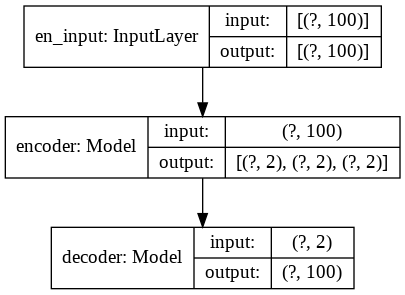

In [ ]:
vae_outs = decoder(encoder(i)[2])
vae = tf.keras.Model(i, vae_outs, name = 'vae')
vae.summary()
tf.keras.utils.plot_model(vae, show_shapes=True)

In [ ]:
def vae_loss(true, pred):
  en_loss = tf.keras.losses.binary_crossentropy(true, pred)
  kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
  kl_loss = K.sum(kl_loss, axis = -1)
  kl_loss *= -0.5
  return K.mean(en_loss + kl_loss)

In [ ]:
vae.compile(optimizer = 'nadam', loss = vae_loss, metrics = ['MSE'])
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)

In [ ]:
class test_eval(tf.keras.callbacks.Callback):
  def __init__(self, x_data, y_data, b_size):
    self.x_data = x_data
    self.y_data = y_data
    self.b_size = b_size
  def on_train_begin(self, logs):
    self.model.test_val = []
  def on_epoch_end(self, epoch, logs):
    results = self.model.evaluate(x = self.x_data, y = self.y_data, batch_size = self.b_size)
    self.model.test_val.append(results)

In [ ]:
history = vae.fit(x = X_train, y = X_train, batch_size = 8, epochs = 50, verbose = 1, validation_split = 0.2, callbacks = [test_eval(X_test, X_test, batch_size), callback])

Train on 49 samples, validate on 13 samples
Epoch 1/50
49/49 [==============================] - 0s 5ms/sample - loss: 4.0240 - MSE: 1.2396 - val_loss: 0.9793 - val_MSE: 1.1863
Epoch 2/50
49/49 [==============================] - 0s 640us/sample - loss: 3.0144 - MSE: 1.2302 - val_loss: 1.3589 - val_MSE: 1.2026
Epoch 3/50
49/49 [==============================] - 0s 695us/sample - loss: 2.0299 - MSE: 1.1989 - val_loss: 1.1826 - val_MSE: 1.2012
Epoch 4/50
49/49 [==============================] - 0s 593us/sample - loss: 1.7522 - MSE: 1.1911 - val_loss: 1.3088 - val_MSE: 1.1971
Epoch 5/50
49/49 [==============================] - 0s 620us/sample - loss: 1.3618 - MSE: 1.1561 - val_loss: 1.1464 - val_MSE: 1.1656
Epoch 6/50
49/49 [==============================] - 0s 649us/sample - loss: 1.2060 - MSE: 1.1322 - val_loss: 2.1394 - val_MSE: 1.2165
Epoch 7/50
49/49 [==============================] - 0s 680us/sample - loss: 0.9193 - MSE: 1.1036 - val_loss: 2.0586 - val_MSE: 1.2098
Epoch 8/50
49/49 [==

In [ ]:
test_loss_history, test_MSE_history = zip(*vae.test_val)

In [ ]:
vae.save('/content/drive/My Drive/Classroom/Biomedical Data Science & AI/test_model.h5')
del vae

In [ ]:
vae = tf.keras.models.load_model('/content/drive/My Drive/Classroom/Biomedical Data Science & AI/test_model.h5', custom_objects = {'vae_loss': vae_loss})
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
en_input (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 6729      
_________________________________________________________________
decoder (Model)              (None, 100)               6775      
Total params: 13,504
Trainable params: 13,204
Non-trainable params: 300
_________________________________________________________________


# 3 MODEL EVALUATION

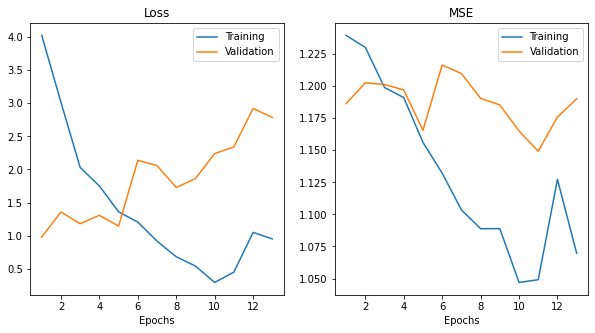

In [ ]:
fig, axis = plt.subplots(1, 2, figsize = (10, 5))
x = [i + 1 for i in history.epoch]
sns.lineplot(x = x, y = history.history['loss'], ax = axis[0], label = 'Training')
sns.lineplot(x = x, y = history.history['val_loss'], ax = axis[0], label = 'Validation', legend="full")
axis[0].set_title('Loss')
axis[0].set_xlabel('Epochs')
sns.lineplot(x = x, y = history.history['MSE'], ax = axis[1], label = 'Training')
sns.lineplot(x = x, y = history.history['val_MSE'], ax = axis[1], label = 'Validation', legend="full")
axis[1].set_title('MSE')
axis[1].set_xlabel('Epochs')
fig.show()

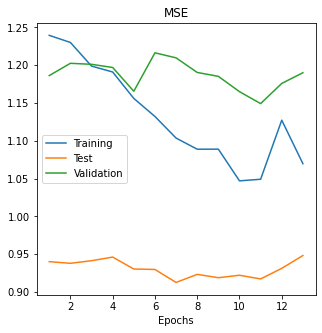

In [ ]:
fig, axis = plt.subplots(1, 1, figsize = (5, 5))
sns.lineplot(x = x, y = history.history['MSE'], ax = axis, label = 'Training')
sns.lineplot(x = x, y = test_MSE_history, ax = axis, label = 'Test')
sns.lineplot(x = x, y = history.history['val_MSE'], ax = axis, label = 'Validation', legend="full")
axis.set_title('MSE')
axis.set_xlabel('Epochs')
fig.show()

# 4 VISUALIZE ALL PATIENTS IN THE 2D FEATURE SPACE SPANNED BY THE THIRD HIDDEN LAYER

In [ ]:
_, _, z_train = encoder.predict(X_train)
_, _, z_test = encoder.predict(X_test)

In [ ]:
train_pred = pd.DataFrame(z_train, columns = ['x latent', 'y latent'])
train_pred['label'] = list(y_train)
train_pred['set type'] = ['Train' for i in train_pred.index]

test_pred = pd.DataFrame(z_test, columns = ['x latent', 'y latent'])
test_pred['label'] = list(y_test)
test_pred['set type'] = ['Test' for i in test_pred.index]

pred_df = pd.concat([train_pred, test_pred])

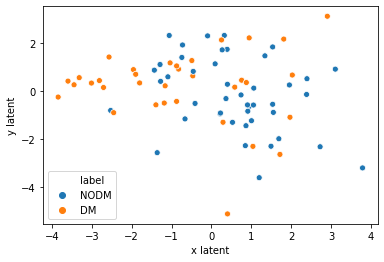

In [ ]:
sns.scatterplot(x = 'x latent', y = 'y latent', data = pred_df, hue = 'label')

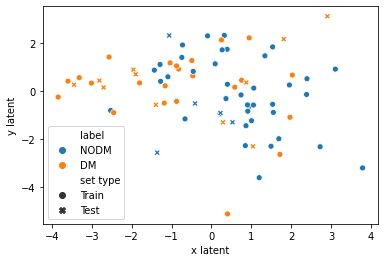

In [ ]:
sns.scatterplot(x = 'x latent', y = 'y latent', data = pred_df, hue = 'label', style = 'set type')